<font size="5"> Perspective transformation </font>

In [1]:
import numpy as np
import cv2
import math

def process_image(image_path, output_path):
    # Read input image and get corners of aruco
    img = cv2.imread(image_path)
    parameters = cv2.aruco.DetectorParameters()
    aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11)
    corners, _, _ = cv2.aruco.detectMarkers(img, aruco_dict, parameters=parameters)

    if len(corners) == 0:
        print(f"No markers found in {image_path}. Skipping.")
        return

    hh, ww = img.shape[:2]

    # Specify input coordinates for corners of detected marker
    input = np.float32(corners[0][0])

    # Output dimensions and coordinates
    width, height = 150, 150 # Physical dimensions
    output = np.float32([[0, 0], [width, 0], [width, height], [0, height]])

    # Compute perspective matrix
    matrix = cv2.getPerspectiveTransform(input, output)

    # Calculate transformed coordinates and bounding box
    original_corners = np.float32([[0, 0], [ww - 1, 0], [ww - 1, hh - 1], [0, hh - 1] ])
    transformed_corners = cv2.perspectiveTransform(np.array([original_corners]), matrix)[0]
    min_x, max_x = np.min(transformed_corners[:, 0]), np.max(transformed_corners[:, 0])
    min_y, max_y = np.min(transformed_corners[:, 1]), np.max(transformed_corners[:, 1])
    bbox_width, bbox_height = int(np.ceil(max_x - min_x)), int(np.ceil(max_y - min_y))

    # Translation matrix and final transformation
    translation_matrix = np.array([[1, 0, -min_x], [0, 1, -min_y], [0, 0, 1]])
    final_matrix = translation_matrix.dot(matrix)

    # Apply transformation and save result
    output_size = (bbox_width, bbox_height)
    imgOutput = cv2.warpPerspective(img, final_matrix, output_size, cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(0, 0, 0))

#     # Display the result
#     cv2.namedWindow("Output Image", cv2.WINDOW_NORMAL)
#     cv2.imshow("Output Image", imgOutput)
#     cv2.waitKey(0)
#     cv2.destroyAllWindows()

    # Save the output image
    cv2.imwrite(output_path, imgOutput)

In [2]:
# List of image paths
image_paths = ["/home/d8/Work/Master_Project/Images/1.jpg", "/home/d8/Work/Master_Project/Images/2.jpg",
              "/home/d8/Work/Master_Project/Images/3.jpg", "/home/d8/Work/Master_Project/Images/4.jpg"]
output_paths = ['/home/d8/Work/Master_Project/Images/11.jpg', "/home/d8/Work/Master_Project/Images/22.jpg",
               '/home/d8/Work/Master_Project/Images/33.jpg', "/home/d8/Work/Master_Project/Images/44.jpg"]

In [3]:
for img_path, out_path in zip(image_paths, output_paths):
    process_image(img_path, out_path)

<font size="5"> Preprocessing images </font>

In [9]:
import cv2
import numpy as np

def process_image_pairs(image_paths, image_paths1, corner_index=0):
    def detect_marker_with_corner(image, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': [0, 0],
            'top-right': [img_width - 1, 0],
            'bottom-left': [0, img_height - 1],
            'bottom-right': [img_width - 1, img_height - 1]
        }

        if ids is not None:
            min_distance = float('inf')
            closest_corner_label = None
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                for label, image_corner in image_corners.items():
                    distance = np.linalg.norm(corner - np.array(image_corner))
                    if distance < min_distance:
                        min_distance = distance
                        closest_corner_label = label
                        closest_marker_corner = corner
                        closest_image_corner = image_corner

            return closest_corner_label, closest_marker_corner, closest_image_corner, min_distance

        return None, None, None, None

    def rotate_image(image, angle):
        if angle == 0:
            return image
        elif angle == 90:
            return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            return cv2.rotate(image, cv2.ROTATE_180)
        elif angle == 270:
            return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    def find_shortest_distance_to_corner(image, target_corner_label, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': np.array([0, 0]),
            'top-right': np.array([img_width - 1, 0]),
            'bottom-left': np.array([0, img_height - 1]),
            'bottom-right': np.array([img_width - 1, img_height - 1])
        }

        if ids is not None:
            min_distance = float('inf')
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                distance = np.linalg.norm(corner - image_corners[target_corner_label])
                if distance < min_distance:
                    min_distance = distance
                    closest_marker_corner = corner
                    closest_image_corner = image_corners[target_corner_label]

            return min_distance, closest_marker_corner, closest_image_corner
        return None, None, None

    # Process each pair of images
    for i in range(len(image_paths)):
        image_path = image_paths[i]
        image_path1 = image_paths1[i]
        
        # Load the images
        image = cv2.imread(image_path)
        image1 = cv2.imread(image_path1)

        # Step 1: Find the closest corner in image
        closest_corner_label, closest_marker_corner, closest_image_corner, min_distance = detect_marker_with_corner(image, corner_index)
        print(f"Closest corner in {image_path}: {closest_corner_label}")
        if closest_marker_corner is not None:
            print(
                f"Shortest line in {image_path} from marker corner {closest_marker_corner} to image corner '{closest_corner_label}' with distance {min_distance:.2f} pixels.")

        # Step 2: Rotate image_path1 and find the best rotation
        best_angle = None
        shortest_distance = float('inf')
        best_marker_corner = None
        best_image_corner = None

        for angle in [0, 90, 180, 270]:
            rotated_image = rotate_image(image1, angle)
            distance, marker_corner, image_corner = find_shortest_distance_to_corner(rotated_image, closest_corner_label, corner_index)

            if distance is not None and distance < shortest_distance:
                shortest_distance = distance
                best_angle = angle
                best_marker_corner = marker_corner
                best_image_corner = image_corner

        # Step 3: Output the best rotation
        print(f"Best rotation angle for {image_path1}: {best_angle}° to match the closest corner '{closest_corner_label}'")
        if best_marker_corner is not None:
            print(
                f"Shortest line in {image_path1} (rotated) from marker corner {best_marker_corner} to image corner '{closest_corner_label}' with distance {shortest_distance:.2f} pixels.")

            # Save the best rotated image without the line
            if best_angle is not None:
                best_rotated_image = rotate_image(image1, best_angle)
                
                # Create the save path for the rotated image
                save_path = image_path1.replace(".jpg", "_rotated.jpg")
                cv2.imwrite(save_path, best_rotated_image)
                print(f"Saved best rotated image to: {save_path}")


In [10]:
# Example usage
image_paths = ['/home/d8/Work/Master_Project/Images/1.jpg',
               '/home/d8/Work/Master_Project/Images/2.jpg',
               '/home/d8/Work/Master_Project/Images/3.jpg',
              '/home/d8/Work/Master_Project/Images/4.jpg']

image_paths1 = ['/home/d8/Work/Master_Project/Images/11.jpg',
                '/home/d8/Work/Master_Project/Images/22.jpg',
                '/home/d8/Work/Master_Project/Images/33.jpg',
               '/home/d8/Work/Master_Project/Images/44.jpg']

# Call the function to process the images
process_image_pairs(image_paths, image_paths1, corner_index=0) 

Closest corner in /home/d8/Work/Master_Project/Images/1.jpg: top-left
Shortest line in /home/d8/Work/Master_Project/Images/1.jpg from marker corner [ 712. 1808.] to image corner 'top-left' with distance 1943.14 pixels.
Best rotation angle for /home/d8/Work/Master_Project/Images/11.jpg: 0° to match the closest corner 'top-left'
Shortest line in /home/d8/Work/Master_Project/Images/11.jpg (rotated) from marker corner [ 445. 1355.] to image corner 'top-left' with distance 1426.20 pixels.
Saved best rotated image to: /home/d8/Work/Master_Project/Images/11_rotated.jpg
Closest corner in /home/d8/Work/Master_Project/Images/2.jpg: top-left
Shortest line in /home/d8/Work/Master_Project/Images/2.jpg from marker corner [1200.  920.] to image corner 'top-left' with distance 1512.08 pixels.
Best rotation angle for /home/d8/Work/Master_Project/Images/22.jpg: 270° to match the closest corner 'top-left'
Shortest line in /home/d8/Work/Master_Project/Images/22.jpg (rotated) from marker corner [754. 657.]

<font size="5">Get the relative locations between markers</font>


In [97]:
from matplotlib import pyplot as plt

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    all_relative_positions = {}

    for idx, img_path in enumerate(img_paths):
        print("[INFO] Loading image...")
        image = cv2.imread(img_path)

        if image is None:
            print("[ERROR] Image not found or cannot be loaded.")
            continue

        if image.shape[0] > image.shape[1]:
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        if ARUCO_DICT.get(aruco_type, None) is None:
            print("[INFO] ArUCo tag of '{}' is not supported".format(aruco_type))
            continue

        print("[INFO] Detecting '{}' tags in {}...".format(aruco_type, img_path))
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
        arucoParams = cv2.aruco.DetectorParameters()
        (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        for i, corner in enumerate(corners):
            marker_corners = corner[0]
            marker_centroid = np.mean(marker_corners, axis=0)

            cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
            cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
            cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                        cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 0, 0), 2)

        if ids is not None:
            marker4_index = np.where(ids == 4)[0]
            if len(marker4_index) == 0:
                print("Marker 4 not found in {}.".format(img_path))
                continue

            marker4_index = marker4_index[0]
            marker4_corners = corners[marker4_index][0]
            marker4_centroid = np.mean(marker4_corners, axis=0)
            print("Center of marker 4: ", marker4_centroid)

            relative_positions = {}
            for i, corner in enumerate(corners):
                if i != marker4_index:
                    marker_corners = corner[0]
                    marker_centroid = np.mean(marker_corners, axis=0)
                    print(f"Center of marker {ids[i][0]}: ", marker_centroid)

                    # Calculate relative position based on image order
                    if idx == 0:
                        relative_position = marker4_centroid - marker_centroid
                    else:
                        relative_position = marker_centroid - marker4_centroid

                    relative_positions[ids[i][0]] = relative_position.tolist()

            all_relative_positions[img_path] = relative_positions

            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            plt.axis('on')
            plt.show()

            # Print relative positions after they've been calculated
            if idx == 0:
                print("Relative positions marker 4 based on first marker in first image {}: {}".format(img_path, relative_positions))
            else:
                print("Relative positions based on marker 4 in {}: {}".format(img_path, relative_positions))

        else:
            print("No markers detected in {}.".format(img_path))

    return all_relative_positions


In [98]:
img_paths = ["/home/d8/Work/Master_Project/Images/22_rotated.jpg", "/home/d8/Work/Master_Project/Images/33_rotated.jpg"]

In [99]:
aruco_type = "DICT_APRILTAG_36h11"

[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/22_rotated.jpg...
Center of marker 4:  [1923.   868.5]
Center of marker 9:  [737.75 968.5 ]


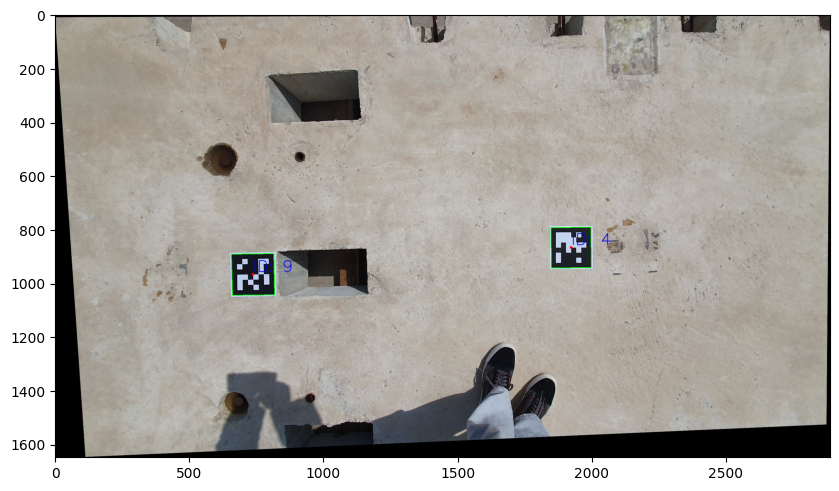

Relative positions marker 4 based on first marker in first image /home/d8/Work/Master_Project/Images/22_rotated.jpg: {9: [1185.25, -100.0]}
[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/33_rotated.jpg...
Center of marker 4:  [512.  823.5]
Center of marker 7:  [1685.75  840.25]


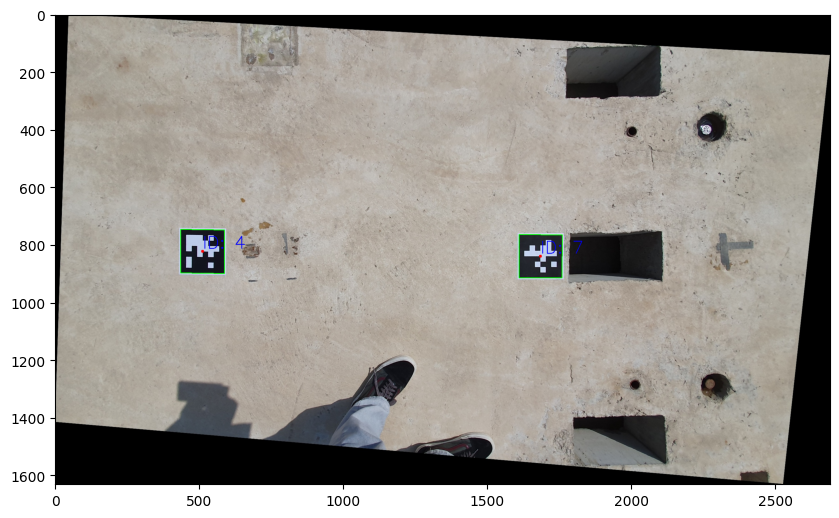

Relative positions based on marker 4 in /home/d8/Work/Master_Project/Images/33_rotated.jpg: {7: [1173.75, 16.75]}


In [100]:
all_relative_positions = detect_aruco_corners(img_paths, aruco_type)

<font size="5">Get the relative locations between shear pocket and markers</font>

In [108]:
# Get the Locations of shear pocket
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_locations_shear_pockets(output_file_path, mask, image_path1):
    # Load the first image (used for contour detection)
    image = cv2.imread(mask, cv2.IMREAD_GRAYSCALE)

    # Load the second image (where points will be drawn)
    image2 = cv2.imread(image_path1)

    # Threshold the first image to binary (black and white)
    _, binary_image = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

    # Find contours in the binary image
    contours, _ = cv2.findContours(binary_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # Sort contours by area and select the top 3 largest contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:3]

    # Open the file to save center points
    with open(output_file_path, 'w') as file:
        for i, contour in enumerate(contours):
            # Get the rotated rectangle
            rect = cv2.minAreaRect(contour)

            # Calculate the center of the box
            center_x = int(rect[0][0])
            center_y = int(rect[0][1])
            
            # Write the center coordinates to the file
            file.write(f"{center_x},{center_y}\n")

            # Print the center coordinates
            print(f"Center of Bounding Box {i + 1}: (x={center_x}, y={center_y})")

            # Draw a circle at the center of the bounding box on the second image
            cv2.circle(image2, (center_x, center_y), 5, (0, 255, 0), -1)  # Green circle with radius 5

    # Convert the image from BGR to RGB for matplotlib
    image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

    # Display the image using plt
    plt.figure(figsize=(10, 10))  # Set the figure size
    plt.imshow(image2_rgb)
    plt.axis('off')  # Hide the axis
    plt.show()

Center of Bounding Box 1: (x=759, y=777)
Center of Bounding Box 2: (x=784, y=2086)
Center of Bounding Box 3: (x=773, y=1430)


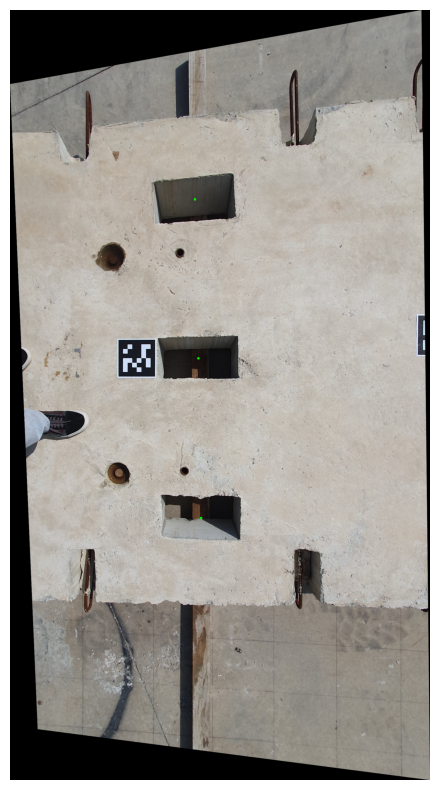

In [148]:
output_file_path = '/home/d8/Work/Master_Project/Shear_Pocket_Locations.txt'
image_path_mask = '/home/d8/Work/yolov9/runs/predict-seg/exp36/masks/11_rotated_combined.png'
image_path1 = '/home/d8/Work/Master_Project/Images/11_rotated.jpg'

detect_locations_shear_pockets(output_file_path, image_path_mask, image_path1)

Center of Bounding Box 1: (x=920, y=865)
Center of Bounding Box 2: (x=927, y=1514)
Center of Bounding Box 3: (x=950, y=2155)


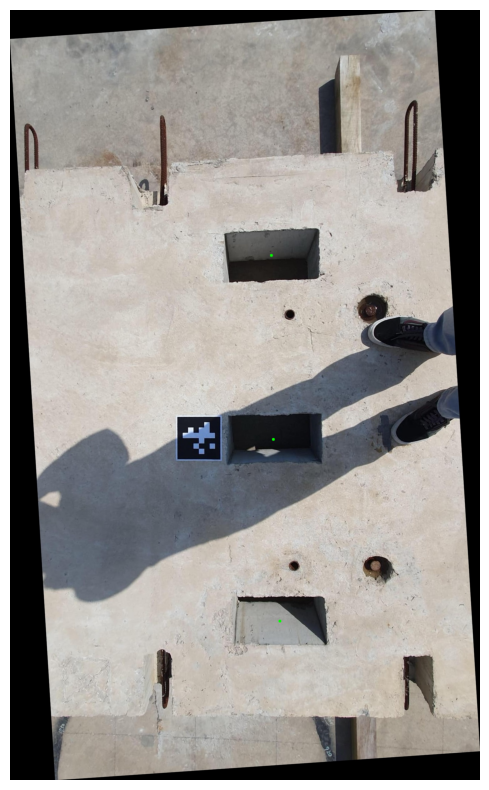

In [149]:
output_file_path = '/home/d8/Work/Master_Project/Shear_Pocket_Locations1.txt'
image_path_mask = '/home/d8/Work/yolov9/runs/predict-seg/exp34/masks/44_rotated_combined.png'
image_path1 = '/home/d8/Work/Master_Project/Images/44_rotated.jpg'

detect_locations_shear_pockets(output_file_path, image_path_mask, image_path1)

In [150]:
# Load x-coordinate values from Locations.txt
file_path1 = "/home/d8/Work/Master_Project/Shear_Pocket_Locations.txt"
with open(file_path1, "r") as f:
    first_line = f.readline()
    second_line = f.readline()
    third_line = f.readline()
    
# Extract coordinates for the first image
A = (int(float(first_line.strip().split(',')[0])), int(float(first_line.strip().split(',')[1])))
B = (int(float(second_line.strip().split(',')[0])), int(float(second_line.strip().split(',')[1])))
C = (int(float(third_line.strip().split(',')[0])), int(float(third_line.strip().split(',')[1])))

file_path2 = "/home/d8/Work/Master_Project/Shear_Pocket_Locations1.txt"
with open(file_path2, "r") as f:
    first_line = f.readline()
    second_line = f.readline()
    third_line = f.readline()
    
# Extract coordinates for the second image
D = (int(float(first_line.strip().split(',')[0])), int(float(first_line.strip().split(',')[1])))
E = (int(float(second_line.strip().split(',')[0])), int(float(second_line.strip().split(',')[1])))
F = (int(float(third_line.strip().split(',')[0])), int(float(third_line.strip().split(',')[1])))

# Print the coordinates
print("Coordinates for Image 1:")
print("A:", A)
print("B:", B)
print("C:", C)

print("Coordinates for Image 2:")
print("D:", D)
print("E:", E)
print("F:", F)


Coordinates for Image 1:
A: (759, 777)
B: (784, 2086)
C: (773, 1430)
Coordinates for Image 2:
D: (920, 865)
E: (927, 1514)
F: (950, 2155)


<font size="5">Get the Y coordinate of every points and markers</font>

<font size="3">Rotate Image and markers</font>

In [151]:
import cv2
import numpy as np

def process_image_pairs(image_paths, image_paths1, image_paths2, corner_index=0):
    def detect_marker_with_corner(image, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': [0, 0],
            'top-right': [img_width - 1, 0],
            'bottom-left': [0, img_height - 1],
            'bottom-right': [img_width - 1, img_height - 1]
        }

        if ids is not None:
            min_distance = float('inf')
            closest_corner_label = None
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                for label, image_corner in image_corners.items():
                    distance = np.linalg.norm(corner - np.array(image_corner))
                    if distance < min_distance:
                        min_distance = distance
                        closest_corner_label = label
                        closest_marker_corner = corner
                        closest_image_corner = image_corner

            return closest_corner_label, closest_marker_corner, closest_image_corner, min_distance

        return None, None, None, None

    def rotate_image(image, angle):
        if angle == 0:
            return image
        elif angle == 90:
            return cv2.rotate(image, cv2.ROTATE_90_CLOCKWISE)
        elif angle == 180:
            return cv2.rotate(image, cv2.ROTATE_180)
        elif angle == 270:
            return cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

    def find_shortest_distance_to_corner(image, target_corner_label, corner_index):
        img_height, img_width = image.shape[:2]
        ARUCO_DICT = cv2.aruco.DICT_APRILTAG_36h11
        arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT)
        arucoParams = cv2.aruco.DetectorParameters()
        corners, ids, rejected = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        image_corners = {
            'top-left': np.array([0, 0]),
            'top-right': np.array([img_width - 1, 0]),
            'bottom-left': np.array([0, img_height - 1]),
            'bottom-right': np.array([img_width - 1, img_height - 1])
        }

        if ids is not None:
            min_distance = float('inf')
            closest_marker_corner = None
            closest_image_corner = None

            for marker_corners in corners:
                corner = marker_corners[0][corner_index]
                distance = np.linalg.norm(corner - image_corners[target_corner_label])
                if distance < min_distance:
                    min_distance = distance
                    closest_marker_corner = corner
                    closest_image_corner = image_corners[target_corner_label]

            return min_distance, closest_marker_corner, closest_image_corner
        return None, None, None

    # Process each pair of images
    for i in range(len(image_paths)):
        image_path = image_paths[i]
        image_path1 = image_paths1[i]
        image_path2 = image_paths2[i]
        
        # Load the images
        image = cv2.imread(image_path)
        image1 = cv2.imread(image_path1)
        image2 = cv2.imread(image_path2)

        # Step 1: Find the closest corner in image
        closest_corner_label, closest_marker_corner, closest_image_corner, min_distance = detect_marker_with_corner(image, corner_index)
        print(f"Closest corner in {image_path}: {closest_corner_label}")
        if closest_marker_corner is not None:
            print(
                f"Shortest line in {image_path} from marker corner {closest_marker_corner} to image corner '{closest_corner_label}' with distance {min_distance:.2f} pixels.")

        # Step 2: Rotate image_path1 and find the best rotation
        best_angle = None
        shortest_distance = float('inf')
        best_marker_corner = None
        best_image_corner = None

        for angle in [0, 90, 180, 270]:
            rotated_image = rotate_image(image1, angle)
            distance, marker_corner, image_corner = find_shortest_distance_to_corner(rotated_image, closest_corner_label, corner_index)

            if distance is not None and distance < shortest_distance:
                shortest_distance = distance
                best_angle = angle
                best_marker_corner = marker_corner
                best_image_corner = image_corner

        # Step 3: Output the best rotation
        print(f"Best rotation angle for {image_path1}: {best_angle}° to match the closest corner '{closest_corner_label}'")
        if best_marker_corner is not None:
            print(
                f"Shortest line in {image_path1} (rotated) from marker corner {best_marker_corner} to image corner '{closest_corner_label}' with distance {shortest_distance:.2f} pixels.")

            # Save the best rotated image without the line
            if best_angle is not None:
                best_rotated_image1 = rotate_image(image1, best_angle)
                
                # Create the save path for the rotated image1
                save_path1 = image_path1.replace(".jpg", "_rotated.jpg")
                cv2.imwrite(save_path1, best_rotated_image1)
                print(f"Saved best rotated image to: {save_path1}")

                # Step 4: Rotate the third image using the same best angle
                best_rotated_image2 = rotate_image(image2, best_angle)

                # Create the save path for the rotated image2
                save_path2 = image_path2.replace(".jpg", "_rotated.jpg")
                cv2.imwrite(save_path2, best_rotated_image2)
                print(f"Saved third image (rotated) to: {save_path2}")


In [152]:
# Example usage - Rotate Image
image_paths = ['../Images/11_rotated.jpg']

image_paths1 = ['../Images/wt22.jpg']
image_paths2 = ['../Images/W11.jpg']

# Call the function to process the images
process_image_pairs(image_paths, image_paths1, image_paths2, corner_index=0) 

Closest corner in ../Images/11_rotated.jpg: top-left
Shortest line in ../Images/11_rotated.jpg from marker corner [ 445. 1355.] to image corner 'top-left' with distance 1426.20 pixels.
Best rotation angle for ../Images/wt22.jpg: 90° to match the closest corner 'top-left'
Shortest line in ../Images/wt22.jpg (rotated) from marker corner [ 500. 1367.] to image corner 'top-left' with distance 1455.57 pixels.
Saved best rotated image to: ../Images/wt22_rotated.jpg
Saved third image (rotated) to: ../Images/W11_rotated.jpg


0.9987394205729166
Point A - Distance (smallest Y): 312.3937971938911
Point B - Distance (smallest Y): 1622.0447161990498
Point C - Distance (smallest Y): 966.2179945259771


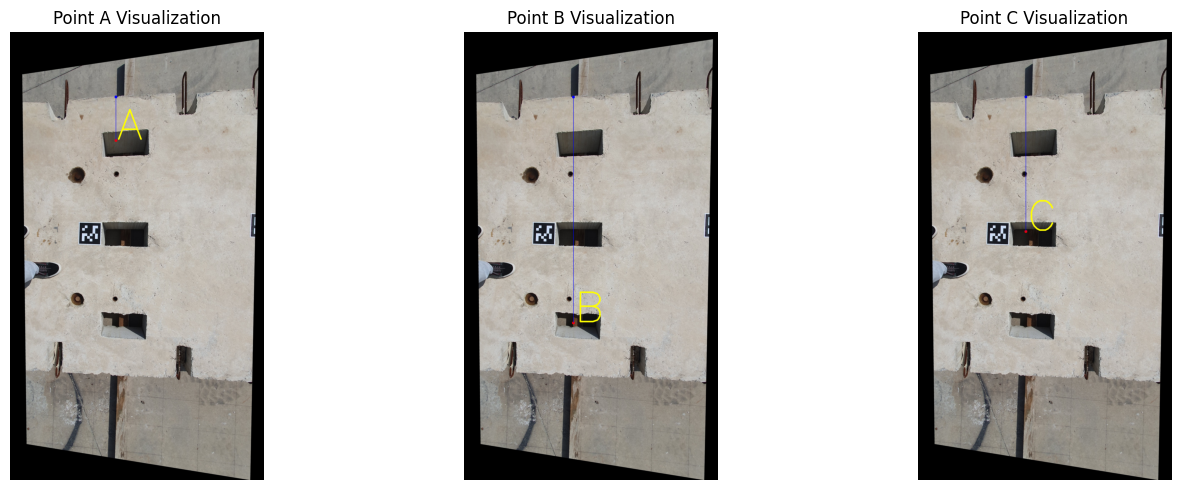

In [155]:
# Points A B C
import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)

# Read the original image
img1 = cv2.imread("../Images/wt22_rotated.jpg")

# Get the ratio of pixel to mm (using ArUco marker)
parameters = cv2.aruco.DetectorParameters()
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11)
corners, _, _ = cv2.aruco.detectMarkers(img1, aruco_dict, parameters=parameters)
# Assuming corners is defined, replace it accordingly
aruco_perimeter = cv2.arcLength(corners[0], True)
pixel_cm_ratio = aruco_perimeter / 600
print(pixel_cm_ratio)

# Read the second image (masks)
img = cv2.imread('../Images/W11_rotated.jpg')

# Find white pixels in the image
y_coords, x_coords = np.where(np.all(img == [255, 255, 255], axis=-1))  # Detect white color pixels
white_pixel_coords = list(zip(x_coords, y_coords))

# Sort white pixels by y and then x
sorted_white_pixel_coords = sorted(white_pixel_coords, key=lambda k: (k[1], k[0]))

# Swap X and Y for each point
A = (A[1], A[0])
B = (B[1], B[0])
C = (C[1], C[0])

# Define points A, B, and C
points = {'A': A, 'B': B, 'C': C}
# Create a list to hold the images with lines drawn
images_with_lines = []

distances = {}

for label, (x, y) in points.items():
    # Get pixels with the same X value and sort by Y
    pixels_with_same_x_as_point = sorted([(px, py) for px, py in sorted_white_pixel_coords if px == x], key=lambda k: k[1])
    # pixels_with_same_x_as_point = sorted([(px, py) for px, py in sorted_white_pixel_coords if py == y], key=lambda k: k[0])
    
    if pixels_with_same_x_as_point:
        point_with_smallest_Y = pixels_with_same_x_as_point[0]  # Point with the smallest Y
        
        # Calculate distances
        distance_smallest_Y = euclidean_distance((x, y), point_with_smallest_Y) / pixel_cm_ratio
        distances[label] = distance_smallest_Y  # Store distance
        
        print(f"Point {label} - Distance (smallest Y): {distance_smallest_Y}")
        
        # Draw on the original image
        img_with_lines = img1.copy()
        
        # Draw points
        cv2.circle(img_with_lines, (x, y), 10, (0, 0, 255), -1)  # Red circle for the original point
        cv2.circle(img_with_lines, point_with_smallest_Y, 10, (255, 0, 0), -1)  # Blue circle for smallest Y point
        
        # Draw lines
        cv2.line(img_with_lines, (x, y), point_with_smallest_Y, (255, 0, 0), 2)  # Blue line
        
        cv2.putText(img_with_lines, label, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 255, 255), 10, cv2.LINE_AA)
        
        # Add image to list
        images_with_lines.append(img_with_lines)
        
    else:
        print(f"No pixels found with the same X value as {label}.")

# Save distances to a CSV file
with open('distances.csv', 'w', newline='') as csvfile:
    fieldnames = ['Point', 'Distance (cm)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for label, distance in distances.items():
        writer.writerow({'Point': label, 'Distance (cm)': distance})

# Display all images horizontally aligned
plt.figure(figsize=(15, 5))

for i, (label, img_with_lines) in enumerate(zip(points.keys(), images_with_lines)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
    plt.title(f"Point {label} Visualization")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [156]:
# Assuming distances dictionary is already populated
print(f"Distance for point A: {distances.get('A', 'Not available'):.2f} mm")
print(f"Distance for point B: {distances.get('B', 'Not available'):.2f} mm")
print(f"Distance for point C: {distances.get('C', 'Not available'):.2f} mm")


Distance for point A: 312.39 mm
Distance for point B: 1622.04 mm
Distance for point C: 966.22 mm


In [157]:
# Example usage - Rotate Image
image_paths = ['../Images/44_rotated.jpg']

image_paths1 = ['/home/d8/Work/Master_Project/Images/wt23.jpg']
image_paths2 = ['../Images/W13.jpg']

# Call the function to process the images
process_image_pairs(image_paths, image_paths1, image_paths2, corner_index=0) 

Closest corner in ../Images/44_rotated.jpg: bottom-left
Shortest line in ../Images/44_rotated.jpg from marker corner [ 740. 1435.] to image corner 'bottom-left' with distance 1478.51 pixels.
Best rotation angle for /home/d8/Work/Master_Project/Images/wt23.jpg: 90° to match the closest corner 'bottom-left'
Shortest line in /home/d8/Work/Master_Project/Images/wt23.jpg (rotated) from marker corner [ 765. 1449.] to image corner 'bottom-left' with distance 1507.52 pixels.
Saved best rotated image to: /home/d8/Work/Master_Project/Images/wt23_rotated.jpg
Saved third image (rotated) to: ../Images/W13_rotated.jpg


0.9968784332275391
Point D - Distance (smallest Y): 325.0145546343127
Point E - Distance (smallest Y): 975.043663902938
Point F - Distance (smallest Y): 1614.03832841546


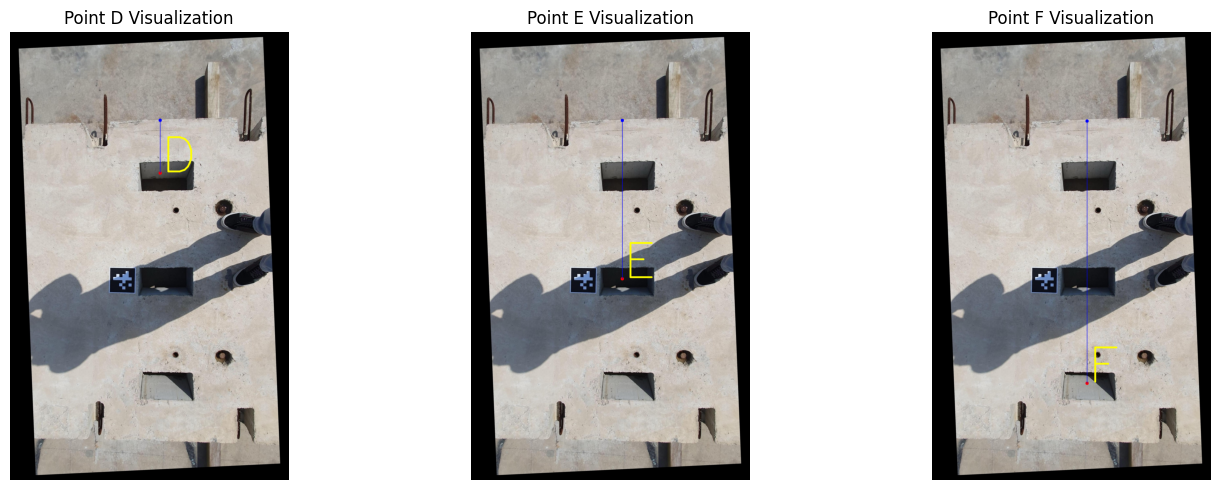

In [158]:
# Points D E F

import cv2
import numpy as np
import matplotlib.pyplot as plt
import csv

# Function to calculate Euclidean distance
def euclidean_distance(point1, point2):
    return np.sqrt((point2[0] - point1[0]) ** 2 + (point2[1] - point1[1]) ** 2)

# Read the original image
img1 = cv2.imread("../Images/wt23_rotated.jpg")

# Get the ratio of pixel to mm (using ArUco marker)
parameters = cv2.aruco.DetectorParameters()
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_APRILTAG_36h11)
corners, _, _ = cv2.aruco.detectMarkers(img1, aruco_dict, parameters=parameters)
# Assuming corners is defined, replace it accordingly
aruco_perimeter = cv2.arcLength(corners[0], True)
pixel_cm_ratio = aruco_perimeter / 600
print(pixel_cm_ratio)

# Read the second image (masks)
img = cv2.imread('../Images/W13_rotated.jpg')

# Find white pixels in the image
y_coords, x_coords = np.where(np.all(img == [255, 255, 255], axis=-1))  # Detect white color pixels
white_pixel_coords = list(zip(x_coords, y_coords))

# Sort white pixels by y and then x
sorted_white_pixel_coords = sorted(white_pixel_coords, key=lambda k: (k[1], k[0]))

# Define points A, B, and C
points = {'D': D, 'E': E, 'F': F}
# Create a list to hold the images with lines drawn
images_with_lines = []

# distances = {}

for label, (x, y) in points.items():
    # Get pixels with the same X value and sort by Y
    pixels_with_same_x_as_point = sorted([(px, py) for px, py in sorted_white_pixel_coords if px == x], key=lambda k: k[1])
    
    if pixels_with_same_x_as_point:
        point_with_smallest_Y = pixels_with_same_x_as_point[0]  # Point with the smallest Y
        
        # Calculate distances
        distance_smallest_Y = euclidean_distance((x, y), point_with_smallest_Y) / pixel_cm_ratio
        distances[label] = distance_smallest_Y  # Store distance
        
        print(f"Point {label} - Distance (smallest Y): {distance_smallest_Y}")
        
        # Draw on the original image
        img_with_lines = img1.copy()
        
        # Draw points
        cv2.circle(img_with_lines, (x, y), 10, (0, 0, 255), -1)  # Red circle for the original point
        cv2.circle(img_with_lines, point_with_smallest_Y, 10, (255, 0, 0), -1)  # Blue circle for smallest Y point
        
        # Draw lines
        cv2.line(img_with_lines, (x, y), point_with_smallest_Y, (255, 0, 0), 2)  # Blue line
        
        cv2.putText(img_with_lines, label, (x + 10, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 10, (0, 255, 255), 10, cv2.LINE_AA)
        
        # Add image to list
        images_with_lines.append(img_with_lines)
        
    else:
        print(f"No pixels found with the same X value as {label}.")

# Save distances to a CSV file
with open('distances.csv', 'w', newline='') as csvfile:
    fieldnames = ['Point', 'Distance (cm)']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    for label, distance in distances.items():
        writer.writerow({'Point': label, 'Distance (cm)': distance})

# Display all images horizontally aligned
plt.figure(figsize=(15, 5))

for i, (label, img_with_lines) in enumerate(zip(points.keys(), images_with_lines)):
    plt.subplot(1, 3, i + 1)
    plt.imshow(cv2.cvtColor(img_with_lines, cv2.COLOR_BGR2RGB))
    plt.title(f"Point {label} Visualization")
    plt.axis('off')

plt.tight_layout()
plt.show()



<font size="5"> Reload Processed images and Obtaning relative position between SPs to  the nearest marker</font>



In [159]:
img_paths1 = ["/home/d8/Work/Master_Project/Images/11_rotated.jpg", "/home/d8/Work/Master_Project/Images/44_rotated.jpg"]

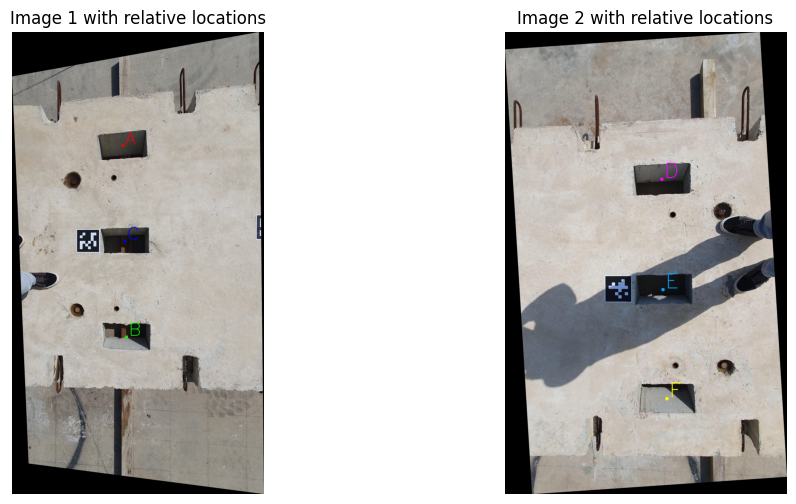

In [160]:
# Read and process the first image
image1 = cv2.imread(img_paths1[0])
# if image1.shape[0] < image1.shape[1]:
#     image1 = cv2.rotate(image1, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Draw circles for points A, B, C on the first image
cv2.circle(image1, A, radius=10, color=(0, 0, 255), thickness=-1)  # Red circle
cv2.circle(image1, B, radius=10, color=(0, 255, 0), thickness=-1)  # Green circle
cv2.circle(image1, C, radius=10, color=(255, 0, 0), thickness=-1)  # Blue circle
cv2.putText(image1, 'A', (A[0] + 15, A[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 0, 255), 4, cv2.LINE_AA)
cv2.putText(image1, 'B', (B[0] + 15, B[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 0), 4, cv2.LINE_AA)
cv2.putText(image1, 'C', (C[0] + 15, C[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 0), 4, cv2.LINE_AA)

# Read and process the second image
image2 = cv2.imread(img_paths1[1])
# if image2.shape[0] < image2.shape[1]:
#     image2 = cv2.rotate(image2, cv2.ROTATE_90_COUNTERCLOCKWISE)

# Draw circles for points D, E, F on the second image
cv2.circle(image2, D, radius=10, color=(255, 0, 255), thickness=-1)  # Red circle
cv2.circle(image2, E, radius=10, color=(255, 165, 0), thickness=-1)  # Green circle
cv2.circle(image2, F, radius=10, color=(0, 255, 255), thickness=-1)  # Blue circle

cv2.putText(image2, 'D', (D[0] + 15, D[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 0, 255), 4, cv2.LINE_AA)
cv2.putText(image2, 'E', (E[0] + 15, E[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (255, 165, 0), 4, cv2.LINE_AA)
cv2.putText(image2, 'F', (F[0] + 15, F[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 4, (0, 255, 255), 4, cv2.LINE_AA)

# Convert BGR images to RGB for Matplotlib
image1_rgb = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2_rgb = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

# Display images using Matplotlib
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image1_rgb)
plt.title("Image 1 with relative locations")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image2_rgb)
plt.title("Image 2 with relative locations")
plt.axis('off')

plt.show()

In [161]:
# calculate_relative_positions of markers and SP
aruco_type = "DICT_APRILTAG_36h11"

def detect_aruco_corners(img_paths, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    if ARUCO_DICT.get(aruco_type, None) is None:
        print(f"[INFO] ArUCo tag of '{aruco_type}' is not supported")
        return None, None

    arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
    arucoParams = cv2.aruco.DetectorParameters()

    centroids = []
    for img_path in img_paths:
        print(f"[INFO] Loading image {img_path}...")
        image = cv2.imread(img_path)
        if image is None:
            print(f"[ERROR] Image {img_path} not found or cannot be loaded.")
            continue

        if image.shape[0] < image.shape[1]:
            # Rotate the image 90 degrees counterclockwise
            image = cv2.rotate(image, cv2.ROTATE_90_COUNTERCLOCKWISE)

        print(f"[INFO] Detecting '{aruco_type}' tags in {img_path}...")
        corners, ids, _ = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

        if ids is not None:
            for i, corner in enumerate(corners):
                marker_corners = corner[0]
                marker_centroid = np.mean(marker_corners, axis=0)

                # Draw marker boundaries
                cv2.polylines(image, [marker_corners.astype(np.int32)], True, (0, 255, 0), 2)
                # Draw marker centroid
                cv2.circle(image, tuple(marker_centroid.astype(int)), 5, (0, 0, 255), -1)
                # Draw marker ID
                cv2.putText(image, f"ID: {ids[i][0]}", tuple(marker_centroid.astype(int) + np.array([0, -10])),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

#             # Display the image with detected markers
#             plt.figure(figsize=(10, 10))
#             plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
#             plt.title(f"Detected ArUco Markers in {img_path}")
#             plt.axis('off')
#             plt.show()

            marker_centroid = np.mean(marker_corners, axis=0)
            centroids.append((marker_centroid, image, corners, ids))
            print(f"Marker found in {img_path} with centroid at {marker_centroid}.")
        else:
            print(f"No markers detected in {img_path}.")

    return centroids


def calculate_relative_positions(centroids):
    if len(centroids) == 2:
        centroid_1, image_1, corners_1, ids_1 = centroids[0]
        centroid_4, image_4, corners_4, ids_4 = centroids[1]

        # Calculate relative positions for A, B, C based on centroid_1
        A_rel = np.array(A) - centroid_1
        B_rel = np.array(B) - centroid_1
        C_rel = np.array(C) - centroid_1

        # Calculate relative positions for D, E, F based on centroid_4
        D_rel = np.array(D) - centroid_4
        E_rel = np.array(E) - centroid_4
        F_rel = np.array(F) - centroid_4

        return (A_rel, B_rel, C_rel), (D_rel, E_rel, F_rel)
    else:
        print("Could not find markers in both images of img_paths1.")
        return None, None

In [162]:
# Detect centroids in the images from img_paths1
centroids1 = detect_aruco_corners(img_paths1, aruco_type)

# Calculate relative positions
rel_positions_1, rel_positions_4 = calculate_relative_positions(centroids1)

if rel_positions_1 and rel_positions_4:
    A_rel, B_rel, C_rel = rel_positions_1
    D_rel, E_rel, F_rel = rel_positions_4

    print(f"Relative positions based on the nearest marker marker in ../Positions/1.jpg:")
    print(f"A_rel: {A_rel}")
    print(f"B_rel: {B_rel}")
    print(f"C_rel: {C_rel}")

    print(f"Relative positions based on nearest marker marker in ../Positions/4.jpg:")
    print(f"D_rel: {D_rel}")
    print(f"E_rel: {E_rel}")
    print(f"F_rel: {F_rel}")
else:
    print("Error in calculating relative positions.")

[INFO] Loading image /home/d8/Work/Master_Project/Images/11_rotated.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/11_rotated.jpg...
Marker found in /home/d8/Work/Master_Project/Images/11_rotated.jpg with centroid at [ 520.   1429.25].
[INFO] Loading image /home/d8/Work/Master_Project/Images/44_rotated.jpg...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags in /home/d8/Work/Master_Project/Images/44_rotated.jpg...
Marker found in /home/d8/Work/Master_Project/Images/44_rotated.jpg with centroid at [ 664.5 1509.5].
Relative positions based on the nearest marker marker in ../Positions/1.jpg:
A_rel: [ 239.   -652.25]
B_rel: [264.   656.75]
C_rel: [253.     0.75]
Relative positions based on nearest marker marker in ../Positions/4.jpg:
D_rel: [ 255.5 -644.5]
E_rel: [262.5   4.5]
F_rel: [285.5 645.5]



<font size="5">Get the final coordinates of shear pockets</font>

In [163]:
def detect_aruco_corners(img, aruco_type):
    ARUCO_DICT = {
        "DICT_4X4_50": cv2.aruco.DICT_4X4_50,
        "DICT_4X4_100": cv2.aruco.DICT_4X4_100,
        "DICT_4X4_250": cv2.aruco.DICT_4X4_250,
        "DICT_4X4_1000": cv2.aruco.DICT_4X4_1000,
        "DICT_5X5_50": cv2.aruco.DICT_5X5_50,
        "DICT_5X5_100": cv2.aruco.DICT_5X5_100,
        "DICT_5X5_250": cv2.aruco.DICT_5X5_250,
        "DICT_5X5_1000": cv2.aruco.DICT_5X5_1000,
        "DICT_6X6_50": cv2.aruco.DICT_6X6_50,
        "DICT_6X6_100": cv2.aruco.DICT_6X6_100,
        "DICT_6X6_250": cv2.aruco.DICT_6X6_250,
        "DICT_6X6_1000": cv2.aruco.DICT_6X6_1000,
        "DICT_7X7_50": cv2.aruco.DICT_7X7_50,
        "DICT_7X7_100": cv2.aruco.DICT_7X7_100,
        "DICT_7X7_250": cv2.aruco.DICT_7X7_250,
        "DICT_7X7_1000": cv2.aruco.DICT_7X7_1000,
        "DICT_ARUCO_ORIGINAL": cv2.aruco.DICT_ARUCO_ORIGINAL,
        "DICT_APRILTAG_16h5": cv2.aruco.DICT_APRILTAG_16h5,
        "DICT_APRILTAG_25h9": cv2.aruco.DICT_APRILTAG_25h9,
        "DICT_APRILTAG_36h10": cv2.aruco.DICT_APRILTAG_36h10,
        "DICT_APRILTAG_36h11": cv2.aruco.DICT_APRILTAG_36h11
    }

    print("[INFO] Loading image...")
    image = cv2.imread(img)

    if ARUCO_DICT.get(aruco_type, None) is None:
        print("[INFO] ArUCo tag of '{}' is not supported".format(aruco_type))
        return None

    print("[INFO] Detecting '{}' tags...".format(aruco_type))
    arucoDict = cv2.aruco.getPredefinedDictionary(ARUCO_DICT[aruco_type])
    arucoParams = cv2.aruco.DetectorParameters()
    (corners, ids, rejected) = cv2.aruco.detectMarkers(image, arucoDict, parameters=arucoParams)

    if corners is not None and len(corners) >= 2:
        return corners

    return None

def calculate_distance_between_markers(marker1_corners, marker2_corners, axis=0):
    # Calculate the centroids of each marker
    center1 = np.mean(marker1_corners, axis=0).squeeze()  # Calculate centroid of marker 1
    center2 = np.mean(marker2_corners, axis=0).squeeze()  # Calculate centroid of marker 2

    # Calculate Euclidean distance between centroids on the specified axis (0 for width, 1 for height)
    distance = np.linalg.norm(center1[axis] - center2[axis])

    return distance

# Load your image
img_path = "../Images/Length/1.jpg"
aruco_type = "DICT_APRILTAG_36h11"
tag_size = 150

image = cv2.imread(img_path)

# Check if the image is horizontal or vertical to adjust the axis for distance calculation
axis = 0 if image.shape[1] > image.shape[0] else 1

# Detect ArUco markers
corners = detect_aruco_corners(img_path, aruco_type)
if corners is not None and len(corners) >= 2:
    marker1_corners, marker2_corners = corners[:2]
    
    # Convert corners to a format suitable for drawing contours
    marker1_corners = marker1_corners.reshape(-1, 1, 2).astype(np.int32)
    marker2_corners = marker2_corners.reshape(-1, 1, 2).astype(np.int32)
    
    # Calculate distance between markers
    distance = calculate_distance_between_markers(marker1_corners, marker2_corners, axis=axis)
    print("Distance between markers in pixel:", distance)

    # Calculate the perimeter of each marker
    perimeter_marker1 = cv2.arcLength(marker1_corners, closed=True)
    perimeter_marker2 = cv2.arcLength(marker2_corners, closed=True)
    
    # Calculate scaling factors
    scaling_factor1 = (tag_size * 4) / perimeter_marker1
    scaling_factor2 = (tag_size * 4) / perimeter_marker2
    a = (scaling_factor2 + scaling_factor1) / 2
    
    # Convert distance from pixels to millimeters
    distance_mm = distance * a
    print("Distance between markers in mm:", distance_mm, "mm")

    # # Draw contours around the markers
    # image = cv2.drawContours(image, [marker1_corners], -1, (0, 255, 0), 2)
    # image = cv2.drawContours(image, [marker2_corners], -1, (0, 255, 0), 2)

    # # Draw a line between the marker centroids
    # center1 = np.mean(marker1_corners, axis=0).astype(int)
    # center2 = np.mean(marker2_corners, axis=0).astype(int)
    # image = cv2.line(image, tuple(center1[0]), tuple(center2[0]), (0, 0, 255), 2)

    # # Calculate midpoint for text position
    # text_position = ((center1[0][0] + center2[0][0]) // 2, (center1[0][1] + center2[0][1]) // 2)

    # # Display the distance as text on the image
    # font = cv2.FONT_HERSHEY_SIMPLEX
    # cv2.putText(image, f"Distance: {distance_mm:.2f} mm", text_position, font, 0.8, (0, 255, 0), 2, cv2.LINE_AA)

    # # Show the result
    # cv2.namedWindow("Detected ArUco Markers", cv2.WINDOW_NORMAL)
    # cv2.imshow("Detected ArUco Markers", image)
    # cv2.waitKey(0)
    # cv2.destroyAllWindows()


[INFO] Loading image...
[INFO] Detecting 'DICT_APRILTAG_36h11' tags...
Distance between markers in pixel: 972.25
Distance between markers in mm: 981.2869104345987 mm


In [164]:
first_img_path = img_paths[0]
first_relative_position = all_relative_positions.get(first_img_path, None)
if first_relative_position:
    first_relative_coordinate = next(iter(first_relative_position.values()))
    print("First relative coordinate based on Marker 2 in {}: {}".format(first_img_path, first_relative_coordinate))
else:
    print("No relative positions found for {}".format(first_img_path))

First relative coordinate based on Marker 2 in /home/d8/Work/Master_Project/Images/22_rotated.jpg: [1185.25, -100.0]


In [165]:
# Final locations A B C
A_final = (A_rel[0] + distance_mm + 80, distances.get('A', 0))
B_final = (B_rel[0] + distance_mm + 80, distances.get('B', 0))
# B_final = (B_rel[0])
C_final = (C_rel[0] + distance_mm + 80, distances.get('C', 0))

print("Final Location A:", A_final)
print("Final Location B:", B_final)
print( "Final Location C:",C_final)

Final Location A: (1300.2869104345987, 312.3937971938911)
Final Location B: (1325.2869104345987, 1622.0447161990498)
Final Location C: (1314.2869104345987, 966.2179945259771)


In [166]:
second_img_path = img_paths[1]
second_relative_position = all_relative_positions.get(second_img_path, None)
if second_relative_position:
    second_relative_coordinate = next(iter(second_relative_position.values()))
    print("second relative coordinate based on Marker 2 in {}: {}".format(second_img_path, second_relative_coordinate))
else:
    print("No relative positions found for {}".format(second_img_path))

second relative coordinate based on Marker 2 in /home/d8/Work/Master_Project/Images/33_rotated.jpg: [1173.75, 16.75]


In [167]:
# Final locations D E F
D_final = ((D_rel + second_relative_coordinate + first_relative_coordinate)[0] + distance_mm + 80, distances.get('D', 0))
E_final = ((E_rel + second_relative_coordinate + first_relative_coordinate)[0] + distance_mm + 80, distances.get('E', 0))
F_final = ((F_rel + second_relative_coordinate + first_relative_coordinate)[0] + distance_mm + 80, distances.get('F', 0))

print("Final Location D:", D_final)
print("Final Location E:", E_final)
print( "Final Location F:",F_final)

Final Location D: (3675.7869104345987, 325.0145546343127)
Final Location E: (3682.7869104345987, 975.043663902938)
Final Location F: (3705.7869104345987, 1614.03832841546)
